### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os

module_dir = "/storage/home/hcoda1/2/cmarutha3/clef/animalclef-2025/"
if module_dir not in sys.path:
    sys.path.append(module_dir)

In [5]:
import torch
import torch.nn
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import matplotlib.pyplot as plt
import umap

le = LabelEncoder()
print(torch.cuda.is_available())
print(torch.__version__)

False
2.6.0+cu124


CPU or CUDA

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
os.getcwd()

'/storage/home/hcoda1/2/cmarutha3/clef/animalclef-2025/user/chand2020'

In [8]:
cwd = os.getcwd()
print("Current Working Directory:", cwd)
os.chdir(os.path.expanduser("~/scratch/"))
print("Changed Working Directory to:", os.getcwd())

Current Working Directory: /storage/home/hcoda1/2/cmarutha3/clef/animalclef-2025/user/chand2020
Changed Working Directory to: /storage/scratch1/2/cmarutha3


In [9]:
file_list = []
for root, dirs, files in os.walk("happy-whale-and-dolphin/train_images/"):
    for file in files:
        file_list.append(file)
len(file_list)

51033

### Extract Data

In [10]:
train_df = pd.read_csv("happy-whale-and-dolphin/train.csv")

In [11]:
train_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [12]:
# Find unique values in the 'id' column
unique_ids = train_df["individual_id"].unique()
print("Unique IDs:", unique_ids)

# Count unique values in the 'id' column
count_unique_ids = train_df["individual_id"].value_counts()
print("Count of Unique IDs:\n", count_unique_ids)

Unique IDs: ['cadddb1636b9' '1a71fbb72250' '60008f293a2b' ... '3509cb6a8504'
 'e880e47c06a4' 'bc6fcab946c4']
Count of Unique IDs:
 individual_id
37c7aba965a5    400
114207cab555    168
a6e325d8e924    155
19fbb960f07d    154
c995c043c353    153
               ... 
df7668d8f754      1
03be3cdbff9c      1
8235d066b9fe      1
d1b416bae01d      1
f727bd52d5dc      1
Name: count, Length: 15587, dtype: int64


In [13]:
# Find unique values in the 'id' column
unique_ids = train_df["species"].unique()
print("Unique IDs:", unique_ids)

# Count unique values in the 'id' column
count_unique_ids = train_df["species"].value_counts()
print("Count of Unique IDs:\n", count_unique_ids)

Unique IDs: ['melon_headed_whale' 'humpback_whale' 'false_killer_whale'
 'bottlenose_dolphin' 'beluga' 'minke_whale' 'fin_whale' 'blue_whale'
 'gray_whale' 'southern_right_whale' 'common_dolphin' 'kiler_whale'
 'pilot_whale' 'dusky_dolphin' 'killer_whale' 'long_finned_pilot_whale'
 'sei_whale' 'spinner_dolphin' 'bottlenose_dolpin' 'cuviers_beaked_whale'
 'spotted_dolphin' 'globis' 'brydes_whale' 'commersons_dolphin'
 'white_sided_dolphin' 'short_finned_pilot_whale' 'rough_toothed_dolphin'
 'pantropic_spotted_dolphin' 'pygmy_killer_whale' 'frasiers_dolphin']
Count of Unique IDs:
 species
bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   112

In [81]:
ids = ["a6e325d8e924", "19fbb960f07d", "37c7aba965a5", "114207cab555"]
species = ["bottlenose_dolphin", "blue_whale", "killer_whale", "beluga"]
# Train Data 1
train_df1 = train_df[train_df["individual_id"].isin(ids)].reset_index(drop=True)
train_df1["individual_id"] = le.fit_transform(train_df1["individual_id"])
train_df1["individual_id_original"] = le.inverse_transform(train_df1["individual_id"])
n_labels1 = train_df1["individual_id"].nunique()
# Train Data 2
train_df2 = train_df[train_df["species"].isin(species)].reset_index(drop=True)
train_df2["species"] = le.fit_transform(train_df2["species"])
train_df2["species_original"] = le.inverse_transform(train_df2["species"])
n_labels2 = train_df2["species"].nunique()

In [86]:
train_df1.head()

,image,species,individual_id,individual_id_original
0,001001f099519f.jpg,minke_whale,1,19fbb960f07d
1,0024057bbc89a4.jpg,minke_whale,0,114207cab555
2,0046ceef89b3fc.jpg,minke_whale,2,37c7aba965a5
3,005e53b1b6aada.jpg,minke_whale,2,37c7aba965a5
4,0106d276033b78.jpg,minke_whale,2,37c7aba965a5


In [87]:
train_df2.head()

,image,species,individual_id,species_original
0,0007d9bca26a99.jpg,2,4b00fe572063,bottlenose_dolphin
1,000a8f2d5c316a.jpg,2,b9907151f66e,bottlenose_dolphin
2,000be9acf46619.jpg,0,afb9b3978217,beluga
3,000c3d63069748.jpg,0,df94b15285b9,beluga
4,000c476c11bad5.jpg,2,b11b2404c7e3,bottlenose_dolphin


In [17]:
# Find unique values in the 'id' column
unique_ids = train_df1["individual_id"].unique()
print("Unique IDs:", unique_ids)

# Count unique values in the 'id' column
count_unique_ids = train_df1["individual_id"].value_counts()
print("Count of Unique IDs:\n", count_unique_ids)

Unique IDs: [1 0 2 3]
Count of Unique IDs:
 individual_id
2    400
0    168
3    155
1    154
Name: count, dtype: int64


In [18]:
# Find unique values in the 'id' column
unique_ids = train_df2["species"].unique()
print("Unique Species:", unique_ids)

# Count unique values in the 'id' column
count_unique_ids = train_df2["species"].value_counts()
print("Count of Unique Species:\n", count_unique_ids)

Unique Species: [2 0 1 3]
Count of Unique Species:
 species
2    9664
0    7443
1    4830
3    1493
Name: count, dtype: int64


### Preprocessing and Model

In [19]:
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_pa

### Dataset

In [51]:
class ExtractDataset1(Dataset):
    def __init__(self, X, y, preprocessor, model, transform=None):
        self.X = X
        self.y = y
        self.preprocessor = preprocessor
        self.transform = transform
        self.model = model

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        item_image = self.X.loc[idx, "image"]
        item_label = self.y.loc[idx, "individual_id"]
        item_image_path = os.path.join(
            "happy-whale-and-dolphin/train_images", item_image
        )
        item_image = Image.open(item_image_path).convert("RGB")
        #         print(item_image.size)

        inputs = self.preprocessor(images=item_image, return_tensors="pt")
        #         print(inputs['pixel_values'].shape)

        with torch.no_grad():
            outputs = self.model(**inputs)
        #             print(outputs.last_hidden_state.shape)
        cls_token = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()
        return cls_token, item_label


class ExtractDataset2(Dataset):
    def __init__(self, X, y, preprocessor, model, transform=None):
        self.X = X
        self.y = y
        self.preprocessor = preprocessor
        self.transform = transform
        self.model = model

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        item_image = self.X.loc[idx, "image"]
        item_label = self.y.loc[idx, "species"]
        item_image_path = os.path.join(
            "happy-whale-and-dolphin/train_images", item_image
        )
        item_image = Image.open(item_image_path).convert("RGB")
        #         print(item_image.size)

        inputs = self.preprocessor(images=item_image, return_tensors="pt")
        #         print(inputs['pixel_values'].shape)

        with torch.no_grad():
            outputs = self.model(**inputs)
        #             print(outputs.last_hidden_state.shape)
        cls_token = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()
        return cls_token, item_label


# def extract_cls_embeddings(data_loader):
#     cls_embeddings_list = []

#     for batch in data_loader:
#         print(f"Batch: {batch}")
#         inputs = processor(batch['pixel_values'], return_tensors='pt')

#         with torch.no_grad():
#             outputs = model(**inputs)

#         cls_embeddings = outputs.last_hidden_state[:, 0, :]
#         cls_embeddings_list.append(cls_embeddings)
#         break

#     return torch.cat(cls_embeddings_list, dim=0)

In [52]:
from sklearn.model_selection import train_test_split

X1 = train_df1[["image", "species"]]
y1 = train_df1["individual_id"]
X2 = train_df2[["image", "individual_id"]]
y2 = train_df2["species"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42
)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)

In [53]:
train_dataset1 = ExtractDataset1(
    X_train1.reset_index(), y_train1.reset_index(), processor, model
)
valid_dataset1 = ExtractDataset1(
    X_test1.reset_index(), y_test1.reset_index(), processor, model
)
# train_loader1 = DataLoader(train_dataset1, batch_size=1, shuffle=True)
# validation_loader1 = DataLoader(valid_dataset1, batch_size=1, shuffle=True)

In [54]:
train_dataset2 = ExtractDataset2(
    X_train2.reset_index(), y_train2.reset_index(), processor, model
)
valid_dataset2 = ExtractDataset2(
    X_test2.reset_index(), y_test2.reset_index(), processor, model
)
# train_loader2 = DataLoader(train_dataset2, batch_size=1, shuffle=True)
# validation_loader2 = DataLoader(valid_dataset2, batch_size=1, shuffle=True)

### Extract CLS Embeddings

In [65]:
cls_tokens = []
labels = []
for idx in range(len(train_dataset1)):
    cls_token, label = train_dataset1[idx]
    cls_tokens.append(cls_token)
    labels.append(label)
    if idx >= 1000:
        break
train_cls_embeddings1 = pd.DataFrame(cls_tokens)
train_cls_embeddings1["label"] = labels

In [66]:
cls_tokens = []
labels = []
for idx in range(len(train_dataset2)):
    cls_token, label = train_dataset2[idx]
    cls_tokens.append(cls_token)
    labels.append(label)
    if idx >= 1000:
        break
train_cls_embeddings2 = pd.DataFrame(cls_tokens)
train_cls_embeddings2["label"] = labels

In [67]:
train_cls_embeddings1.to_parquet("train_cls_embeddings1.parquet", engine="pyarrow")
train_cls_embeddings2.to_parquet("train_cls_embeddings2.parquet", engine="pyarrow")

/storage/scratch1/2/cmarutha3/.venv/lib64/python3.9/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [68]:
train_cls_embeddings1 = pd.read_parquet(
    "train_cls_embeddings1.parquet", engine="pyarrow"
)
train_cls_embeddings2 = pd.read_parquet(
    "train_cls_embeddings2.parquet", engine="pyarrow"
)

/storage/scratch1/2/cmarutha3/.venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


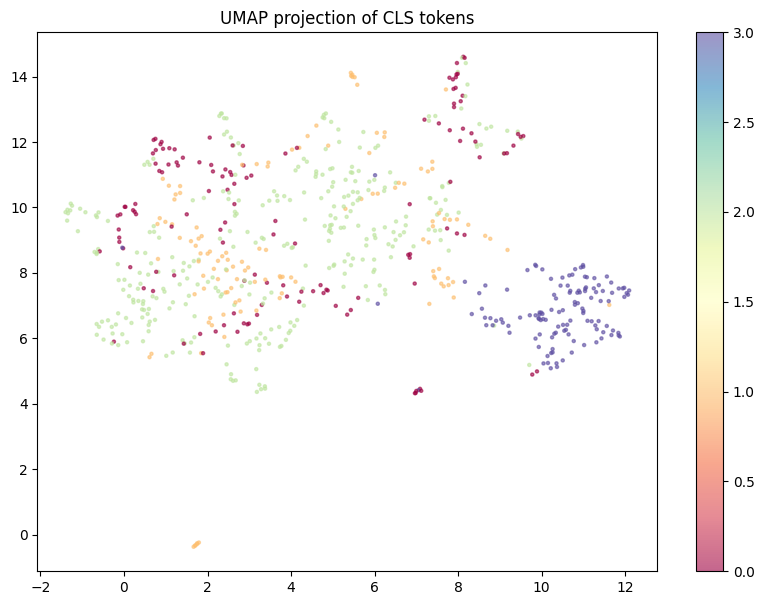

In [95]:
features = train_cls_embeddings1.drop("label", axis=1).values
labels = train_cls_embeddings1["label"].values
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="correlation")
umap_embeddings = umap_model.fit_transform(features)
plt.figure(figsize=(10, 7))
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=labels,
    cmap="Spectral",
    alpha=0.6,
    s=5,
)
plt.colorbar()
plt.title("UMAP projection of CLS tokens")
plt.show()

/storage/scratch1/2/cmarutha3/.venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


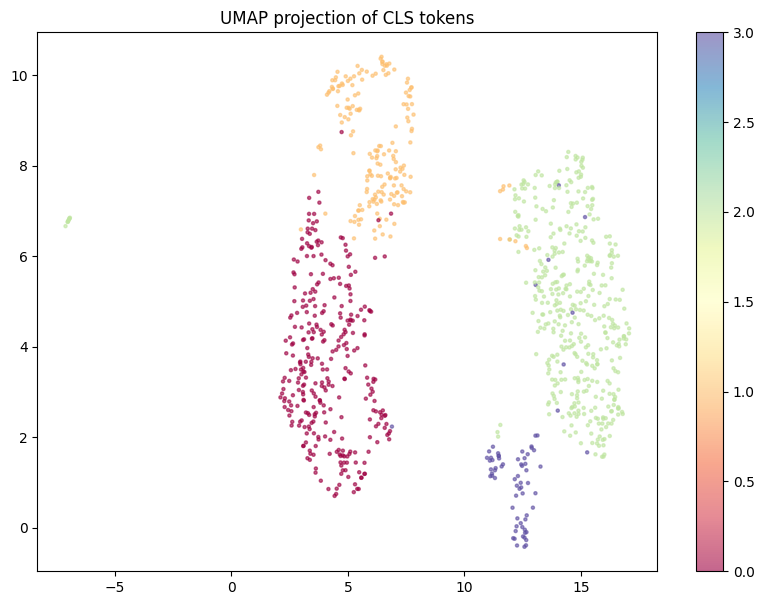

In [96]:
features = train_cls_embeddings2.drop("label", axis=1).values
labels = train_cls_embeddings2["label"].values
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="correlation")
umap_embeddings = umap_model.fit_transform(features)
plt.figure(figsize=(10, 7))
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=labels,
    cmap="Spectral",
    alpha=0.6,
    s=5,
)
plt.colorbar()
plt.title("UMAP projection of CLS tokens")
plt.show()

In [ ]:
labels = train_cls_embeddings2["label"].values
labels = le.inverse_transform(labels)
species = ["bottlenose_dolphin", "blue_whale", "killer_whale", "beluga"]

1001